<a href="https://colab.research.google.com/github/chenyu313/Colaboratory_note/blob/main/Bert_Note.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 模型描述
BERT是以自我监督的方式在大量英语数据语料库上进行预训练的transformers模型。这意味着它只在原始文本上进行了预训练，没有人为以任何方式对它们进行标记(这就是为什么它可以使用大量公开可用的数据)，并通过自动过程从这些文本中生成输入和标签。更准确地说，它的预训练有两个目标:
* 掩码语言建模(MLM)：以一个句子为例，模型随机掩码输入中15%的单词，然后通过模型运行整个掩码句子，并预测被掩码单词。这与传统的循环神经网络(RNN)不同，传统的递归神经网络通常一个接一个地看到单词，也不同于像GPT这样的自回归模型，它在内部掩盖了未来的标记。它允许模型学习句子的双向表示。

* 下一句预测(NSP)：模型在预训练期间连接两个被屏蔽的句子作为输入。有时它们与原文中相邻的句子相对应，有时则相反。然后，该模型必须预测这两个句子是否相互关联。

通过这种方式，模型学习了英语语言的内部表示，然后可以用来提取对下游任务有用的特征:例如，如果你有一个标记句子的数据集，你可以使用BERT模型产生的特征作为输入来训练一个标准分类器。

## 训练数据
BERT模型是在BookCorpus上进行预训练的，BookCorpus是一个由11038本未出版的书籍和英文维基百科(不包括列表、表格和标题)组成的数据集。

### 训练过程
* 预处理：文本使用WordPiece进行标记，词汇量为30,000。模型的输入是这样的:

[CLS] Sentence A [SEP] Sentence B [SEP]  

在0.5的概率下，句子A和句子B对应于原始语料库中的两个连续句子，在其他情况下，它是语料库中的另一个随机句子。注意，这里所说的一个句子是一个连续的文本，通常比一个句子长。唯一的约束是两个“句子”的结果的总长度小于512个标记。  

每个句子的掩蔽程序细节如下:  
1）15%的tokens被掩盖了。  
2）在80%的情况下，掩码令牌被[MASK]取代。  
3）在10%的情况下，被屏蔽的令牌会被一个与其所替换的随机令牌(不同)所替换。  
4）在剩下的10%的情况下，掩码令牌保持原样。


* 预训练：该模型在Pod配置的4个云TPU(共16个TPU芯片)上进行100万步的训练，批大小为256。对于90%的步骤，序列长度被限制为128个标记，其余10%的步骤被限制为512个标记。使用的优化器为Adam，其学习率为1e-4， α1 =0.9 β1 =0.9和α2 =0.999 β2 =0.999，权值衰减为0.01，学习率预热10000步，之后学习率线性衰减。

* 评价结果：当对下游任务进行微调时，该模型实现了以下结果
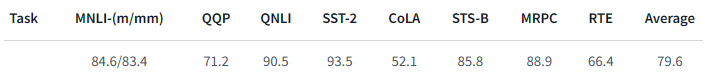


## 具体使用

In [ ]:
!pip install transformers

In [2]:
from transformers import pipeline
unmasker = pipeline('fill-mask', model='bert-base-cased')
unmasker("Hello I'm a [MASK] model.")


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[{'score': 0.09019182622432709,
  'token': 4633,
  'token_str': 'fashion',
  'sequence': "Hello I'm a fashion model."},
 {'score': 0.0635000690817833,
  'token': 1207,
  'token_str': 'new',
  'sequence': "Hello I'm a new model."},
 {'score': 0.06228196248412132,
  'token': 2581,
  'token_str': 'male',
  'sequence': "Hello I'm a male model."},
 {'score': 0.0441727377474308,
  'token': 1848,
  'token_str': 'professional',
  'sequence': "Hello I'm a professional model."},
 {'score': 0.03326152265071869,
  'token': 7688,
  'token_str': 'super',
  'sequence': "Hello I'm a super model."}]

在Pytorch中使用这个模型获取指定的文本

In [6]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = BertModel.from_pretrained("bert-base-cased")
text = "Replace me by any text you'd like."
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
